# Inversion of DC & IP data at the Century Deposit

The Century Deposit is a Zinc-lead-silver deposit is located 250 km to the NNW of the Mt Isa region in Queensland Australia (Location: 18° 43' 15"S, 138° 35' 54"E). 

<img src="./images/Mutton-Figure1-1.png" width=50%>



- https://doi.org/10.1190/1.1444878 

- [geologic background](http://www.portergeo.com.au/database/mineinfo.asp?mineid=mn075)

For background on DC Resistivity Surveys, see [GPG: DC Resistivity](https://gpg.geosci.xyz/content/DC_resistivity/index.html)

In this notebook, we are going to invert the data and see if we can replicate the results presented in [Mutton, 2000](https://doi.org/10.1190/1.1444878). Specifically, we will work with data collected along the line 46800mE. 

In [1]:
# core python 
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets  # for interactive widgets
from matplotlib.colors import LogNorm

# tools in the simPEG Ecosystem 
import discretize  # for creating computational meshes

try: 
    from pymatsolver import Pardiso as Solver  # this is a fast linear solver 
except ImportError:
    from SimPEG import SolverLU as Solver  # this will be slower

from SimPEG import (
    Data, maps,
    data_misfit, regularization, optimization, inverse_problem, 
    inversion, directives
) 
from SimPEG.electromagnetics import resistivity as dc

In [2]:
from matplotlib import rcParams
rcParams["font.size"] = 14

## Data

The survey collected at the Century Deposit uses a dipole-dipole geometry with:
- Current Electrodes (A, B): we refer to the source electrodes as "A" for the positive electrode and "B" for the negative electrode. 
- Potential Electrodes (M, N): we refer to the positive potential electrode as "M" and the negative as "N".

A datum is the potential difference between the M and N electrodes. 

<img src="https://gpg.geosci.xyz/_images/add1.gif">

<img src="https://gpg.geosci.xyz/_images/add2.gif">

In [3]:
!ls ./century/*.OBS

ls: ./century/*.OBS: No such file or directory


All of the data are in the `century` directory. `POT` referrs to "Potentials" - these are our DC data and `IP` referrs to "Induced Polarization". These file formats are an older version of the UBC DC format and are very similar to the current [UBC DC IP Surface Format](https://giftoolscookbook.readthedocs.io/en/latest/content/fileFormats/dcip2dObsfile.html#surface-format)

```
Comment line: description of data
   n_sources ? ? 
     A_location  B_location   n_receivers
   M_location  N_location  measured_potential  standard_deviation
   M_location  N_location  measured_potential  standard_deviation
     A_location  B_location   n_receivers
   M_location  N_location  measured_potential  standard_deviation
   M_location  N_location  measured_potential  standard_deviation
   ....
```

In [4]:
line = 46800 
dc_data_file = f"./century/{line}E/{line}POT.OBS"

In [5]:
!cat {dc_data_file}

AVG-GDAT 1.22: CENTURY Converted by RES2POT to conductivitie
   27    1    1
    26000.000000    26100.000000           2
   26700.0   26800.0   -.00127    .00006
   26800.0   26900.0   -.00080    .00004
    26100.000000    26200.000000           3
   26700.0   26800.0   -.00164    .00008
   26800.0   26900.0   -.00099    .00005
   26900.0   27000.0   -.00063    .00003
    26200.000000    26300.000000           4
   26700.0   26800.0   -.00252    .00013
   26800.0   26900.0   -.00146    .00007
   26900.0   27000.0   -.00088    .00004
   27000.0   27100.0   -.00125    .00006
    26300.000000    26400.000000           5
   26700.0   26800.0   -.00504    .00025
   26800.0   26900.0   -.00260    .00013
   26900.0   27000.0   -.00147    .00007
   27000.0   27100.0   -.00195    .00010
   27100.0   27200.0   -.00103    .00005
    26400.000000    26500.000000           6
   26700.0   26800.0   -.01048    .00052
   26800.0   26900.0   -.00472    .00024
   26900.0   27000.0   -.00249    .00012
 

In [6]:
def read_dcip_data(filename):
    """
    Read in a .OBS file from the Century data set into a python dictionary. 
    The format is the old UBC-GIF DCIP format.
    
    Parameters
    ----------
    filename : str
        Path to the file to be parsed
    
    
    Returns
    -------
    dict
        A dictionary with the locations of
        - a_locations: the positive source electrode locations (numpy array) 
        - b_locations: the negative source electrode locations (numpy array) 
        - m_locations: the receiver locations (list of numpy arrays)
        - n_locations: the receiver locations (list of numpy arrays)
        - n_locations: the receiver locations (list of numpy arrays)
        - observed_data: observed data (list of numpy arrays)
        - standard_deviations: assigned standard deviations (list of numpy arrays)
        - n_sources: number of sources (int)
    
    """
    
    # read in the text file as a numpy array of strings (each row is an entry)
    contents = np.genfromtxt(filename, delimiter=' \n', dtype=np.str)
    
    # the second line has the number of sources, current, and data type (voltages if 1)
    n_sources = int(contents[1].split()[0])
    print(f"number of sources: {n_sources}")
    
    # initialize storage for the electrode locations and data
    a_locations = np.zeros(n_sources)
    b_locations = np.zeros(n_sources)
    m_locations = []
    n_locations = []
    observed_data = []
    standard_deviations = []
    
    # index to track where we have read in content 
    content_index = 1 
    
    # loop over sources 
    for i in range(n_sources):
        # start by reading in the source info 
        content_index = content_index + 1  # read the next line
        a_location, b_location, nrx = contents[content_index].split()  # this is a string

        # convert the strings to a float for locations and an int for the number of receivers
        a_locations[i] = float(a_location)
        b_locations[i] = float(b_location)
        nrx = int(nrx)

        print(f"Source {i}: A-loc: {a_location}, B-loc: {b_location}, N receivers: {nrx}")

        # initialize space for receiver locations, observed data associated with this source
        m_locations_i, n_locations_i = np.zeros(nrx), np.zeros(nrx)
        observed_data_i, standard_deviations_i = np.zeros(nrx), np.zeros(nrx)

        # read in the receiver info 
        for j in range(nrx):
            content_index = content_index + 1  # read the next line
            m_location, n_location, datum, std = contents[content_index].split()

            # convert the locations and data to floats, and store them
            m_locations_i[j] = float(m_location)
            n_locations_i[j] = float(n_location)
            observed_data_i[j] = float(datum)
            standard_deviations_i[j] = float(std)

        # append the receiver info to the lists
        m_locations.append(m_locations_i)
        n_locations.append(n_locations_i)
        observed_data.append(observed_data_i)
        standard_deviations.append(standard_deviations_i)
    
    return {
        "a_locations": a_locations,
        "b_locations": b_locations, 
        "m_locations": m_locations,
        "n_locations": n_locations,
        "observed_data": observed_data, 
        "standard_deviations": standard_deviations,
        "n_sources": n_sources, 
    }

In [7]:
# sanity check 
dc_data_dict = read_dcip_data(dc_data_file)

number of sources: 27
Source 0: A-loc: 26000.000000, B-loc: 26100.000000, N receivers: 2
Source 1: A-loc: 26100.000000, B-loc: 26200.000000, N receivers: 3
Source 2: A-loc: 26200.000000, B-loc: 26300.000000, N receivers: 4
Source 3: A-loc: 26300.000000, B-loc: 26400.000000, N receivers: 5
Source 4: A-loc: 26400.000000, B-loc: 26500.000000, N receivers: 6
Source 5: A-loc: 26500.000000, B-loc: 26600.000000, N receivers: 7
Source 6: A-loc: 26600.000000, B-loc: 26700.000000, N receivers: 7
Source 7: A-loc: 26700.000000, B-loc: 26800.000000, N receivers: 6
Source 8: A-loc: 26800.000000, B-loc: 26900.000000, N receivers: 6
Source 9: A-loc: 26900.000000, B-loc: 27000.000000, N receivers: 6
Source 10: A-loc: 27000.000000, B-loc: 27100.000000, N receivers: 6
Source 11: A-loc: 27100.000000, B-loc: 27200.000000, N receivers: 6
Source 12: A-loc: 27200.000000, B-loc: 27300.000000, N receivers: 6
Source 13: A-loc: 27300.000000, B-loc: 27400.000000, N receivers: 6
Source 14: A-loc: 27400.000000, B-lo

## Create a SimPEG survey

In SimPEG, the `survey` object keeps track of the geometry and type of sources and receivers.  Similar to the way the data file was structured, each `source` takes a `receiver_list` which knows about the different receiver types that are "listening" to that source. 

For example, for the first source, we have dipole receivers at 2 different locations. A SimPEG receiver object can have multiple locations, so conceptually, we can think of a receiver object containing all receivers of one type. If we also had a pole-source, then we would add another receiver type to our receiver list. Since we will run 2D simulations and inversions, then the receivers need to be defined in 2D space `[x, z]`. The receivers are on the surface of the Earth, and in this example, we will not consider topography, so they are at `z=0`.

```python

m_locs = np.array([
    [26700.0, 0.],
    [26800.0, 0.]
])

n_locs = np.array([
    [26800.0, 0.],
    [26900.0, 0.]
])

rx = dc.receivers.Dipole(m_locations=m_locs, n_locations=n_locs) 
rx_list = [rx]

```

A source in SimPEG has a single location. For the first source: 
```python 

a_loc = np.r_[26000.0, 0.]
b_loc = np.r_[26100.0, 0.]

src = dc.sources.Dipole(a_location=a_loc, b_location=b_loc, receiver_list=rx_list)
```

Finally, the survey is instantiated with a source list which contains all of the sources and their associated receiver lists
```python
survey = dc.Survey(source_list=[src1, src2, ...])
```

In [8]:
# initialize an empty list for each 
source_list = []

for i in range(dc_data_dict["n_sources"]):
    
    # receiver electrode locations in 2D 
    m_locs = np.vstack([
        dc_data_dict["m_locations"][i], 
        np.zeros_like(dc_data_dict["m_locations"][i])
    ]).T
    n_locs = np.vstack([
        dc_data_dict["n_locations"][i],
        np.zeros_like(dc_data_dict["n_locations"][i])
    ]).T
    
    # construct the receiver object 
    receivers = dc.receivers.Dipole(m_locations=m_locs, n_locations=n_locs)
    
    # construct the source 
    source = dc.sources.Dipole(
        a_location=np.r_[dc_data_dict["a_locations"][i], 0.],
        b_location=np.r_[dc_data_dict["b_locations"][i], 0.],
        receiver_list=[receivers]
    )
    
    # append the new source to the source list
    source_list.append(source)

In [9]:
survey = dc.Survey(source_list=source_list)

## Observed Data 

The data object. 

In [10]:
dc_data = Data(
    survey=survey, 
    dobs=np.hstack(dc_data_dict["observed_data"]),
    standard_deviation=np.hstack(dc_data_dict["standard_deviations"])
)

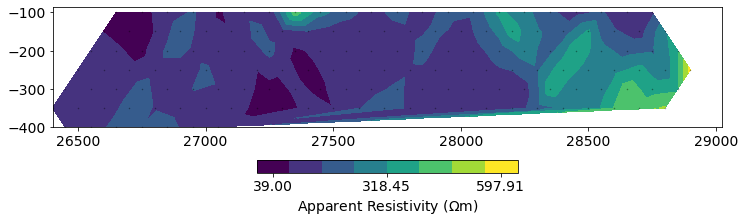

In [11]:
# plot psuedosection
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
dc.utils.plot_pseudosection(
    dc_data, data_type="apparent resistivity", 
    plot_type="contourf", data_location=True, ax=ax, 
)
ax.set_aspect(1.5)  # some vertical exxageration

In [12]:
def plot_building_pseudosection(source_ind=0):
    """
    A plotting function to visualize how a pseudosection is built up. 
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    mid_x, mid_z = dc.utils.source_receiver_midpoints(dc_data.survey)
    ax.plot(mid_x, mid_z, '.k', alpha=0.5)
    
    # plot the source location
    a_loc = dc_data_dict["a_locations"][source_ind]
    b_loc = dc_data_dict["b_locations"][source_ind]
    src_mid = (a_loc+b_loc)/2
    ax.plot(np.r_[a_loc, b_loc], np.r_[0, 0], 'C0.')
    ax.plot(src_mid, np.r_[0], 'C0x', ms=6)

    # plot the receiver locations
    m_locs = dc_data_dict["m_locations"][source_ind]
    n_locs = dc_data_dict["n_locations"][source_ind]
    rx_mid = (m_locs+n_locs)/2
    ax.plot(np.r_[m_locs, n_locs], np.zeros(2*len(m_locs)), 'C1.')
    ax.plot(rx_mid, np.zeros_like(m_locs), 'C1x', ms=6)
    
    # plot where the pseudosection points should be 
    pseudo_x = (rx_mid + src_mid)/2.
    pseudo_z = -np.abs(rx_mid-src_mid)/2.
    
    ax.plot(np.r_[src_mid, pseudo_x], np.r_[0, pseudo_z], '-k', alpha=0.3)
    
    for rx_x, px, pz in zip(rx_mid, pseudo_x, pseudo_z): 
        ax.plot(np.r_[px, rx_x], np.r_[pz, 0], '-k', alpha=0.3)
        
    ax.plot(pseudo_x, pseudo_z, 'C2o')
    
    ax.set_xlim([25900, 29200])
    ax.set_aspect(1.5) #
    

In [13]:
ipywidgets.interact(
    plot_building_pseudosection, 
    source_ind=ipywidgets.IntSlider(min=0, max=int(dc_data_dict["n_sources"])-1, value=0)
)

interactive(children=(IntSlider(value=0, description='source_ind', max=26), Output()), _dom_classes=('widget-i…

<function __main__.plot_building_pseudosection(source_ind=0)>

Text(0, 0.5, 'Pseudo-depth')

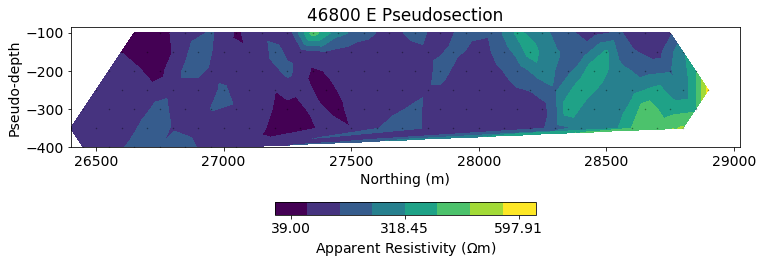

In [14]:
# plot psuedosection
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
dc.utils.plot_pseudosection(
    dc_data, data_type="apparent resistivity", 
    plot_type="contourf", data_location=True, ax=ax, cbar_opts={"pad":0.25}
)
ax.set_aspect(1.5)  # some vertical exxageration
ax.set_title(f"{line} E Pseudosection")
ax.set_xlabel("Northing (m)")
ax.set_ylabel("Pseudo-depth")


In [15]:
apparent_resistivity = dc.utils.apparent_resistivity(dc_data)

Text(0, 0.5, 'log$_{10}(\\rho_a)$')

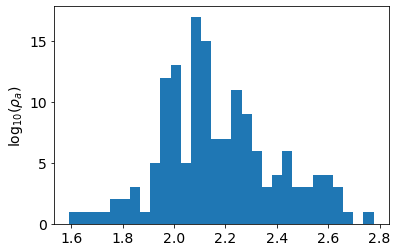

In [16]:
fig, ax = plt.subplots(1, 1)
out = ax.hist(np.log10(apparent_resistivity), bins=30)
ax.set_ylabel("log$_{10}(\\rho_a)$")

In [17]:
rho0 = 10**np.median(np.log10(apparent_resistivity))
rho0

135.9061948142914

## set up the forward simulation machinery

### Step 1: design a Tensor mesh

In [18]:
# use an OcTree mesh

min_electrode_spacing = np.min(np.abs(survey.a_locations[:, 0] - survey.b_locations[:, 0]))
n_cells_per_spacing = 4

dx = min_electrode_spacing / n_cells_per_spacing
dz = 0.5 * min_electrode_spacing / n_cells_per_spacing

print(
    f"We will use a base mesh with {dx} m x {dz} m cells"
)

We will use a base mesh with 25.0 m x 12.5 m cells


In [19]:
domain_x = np.r_[
    survey.electrode_locations[:, 0].min(),
    survey.electrode_locations[:, 0].max()
]

domain_z = np.r_[-300, 0.]

In [20]:
n_core_extra = 4 
n_core_x = np.ceil(np.diff(domain_x)/dx) + n_core_extra*2  # on each side
n_core_z = np.ceil(np.diff(domain_z)/dz) + n_core_extra  # just below

padding_factor = 1.3
n_pad_x = 5
n_pad_z = 5

In [21]:
hx = [(dx, n_pad_x, -padding_factor), (dx, n_core_x), (dx, n_pad_x, padding_factor)]
hz = [(dz, n_pad_z, -padding_factor), (dz, n_core_z)]

mesh = discretize.TensorMesh([hx, hz])

mesh.x0 = np.r_[
    -mesh.hx[:n_pad_x + n_core_extra].sum() + domain_x.min(),
    -mesh.hy.sum()
]

mesh

TensorMesh: 4,818 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    146     25,606.10     29,593.90     25.00     92.82    1.30
   y     33       -496.95          0.00     12.50     46.41    1.30

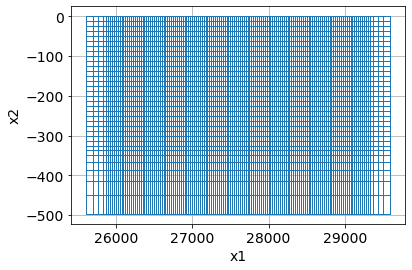

In [22]:
mesh.plotGrid()

## Step 2: Construct the forward simulation

In [23]:
# forward simulation 
# Use Exponential Map: m = log(rho)
mapping = maps.ExpMap(mesh)

# Generate 2.5D DC problem
# "N" means potential is defined at nodes
simulation = dc.simulation_2d.Simulation2DNodal(
    mesh, sigmaMap=mapping, solver=Solver, survey=survey, storeJ=True
)

In [24]:
%%time 

# run the forward simulation over the half-space & plot apparent resistivities
m0 = np.ones(mesh.nC) * np.log(1./rho0)
d0 = simulation.make_synthetic_data(m0)

CPU times: user 1.28 s, sys: 86.7 ms, total: 1.36 s
Wall time: 395 ms


Text(0, 0.5, 'Pseudo-depth')

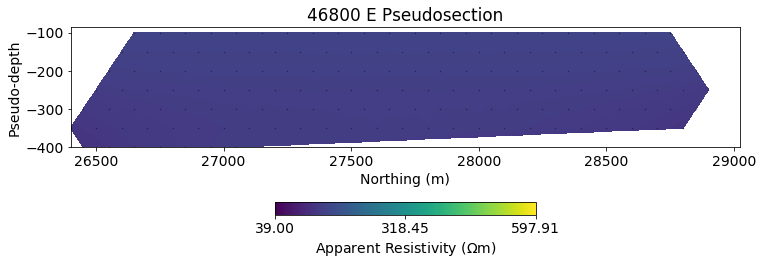

In [25]:
# plot psuedosection
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

clim = np.r_[apparent_resistivity.min(), apparent_resistivity.max()]
dc.utils.plot_pseudosection(
    d0, data_type="apparent resistivity", clim=clim,
    plot_type="pcolor", data_location=True, ax=ax, 
    cbar_opts={"pad":0.25}
)
ax.set_aspect(1.5)  # some vertical exxageration
ax.set_title(f"{line} E Pseudosection")
ax.set_xlabel("Northing (m)")
ax.set_ylabel("Pseudo-depth")


# Set up the inversion

In [26]:
# set up inversion 
dmisfit = data_misfit.L2DataMisfit(data=dc_data, simulation=simulation)

# Related to inversion
reg = regularization.Tikhonov(
    mesh, 
    alpha_s=1./mesh.hx.min()**2,
    alpha_x=1, alpha_y=1,
)

In [27]:
opt = optimization.InexactGaussNewton(maxIter=20)
invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt)


# directives
beta = directives.BetaSchedule(coolingFactor=4, coolingRate=2)
betaest = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
target = directives.TargetMisfit()

inv = inversion.BaseInversion(
    invProb, directiveList=[
        beta, target, betaest 
    ]
)
opt.remember('xc')

# Run inversion
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  7.70e+00  1.05e+04  0.00e+00  1.05e+04    2.73e+03      0              
   1  7.70e+00  2.04e+03  4.39e+01  2.38e+03    3.91e+02      0              
   2  1.92e+00  7.64e+02  1.05e+02  9.65e+02    1.05e+02      0   Skip BFGS  
   3  1.92e+00  1.61e+02  2.20e+02  5.84e+02    6.57e+01      0   Skip BFGS  
   4  4.81e-01  1.26e+02  2.19e+02  2.31e+02    3.95e+01      0              
   5  4.81e-01  9.50e+01  2.37e+02  2.09e+02    4.29e+01      0              
   6  1.20e-01  8.75e+01  2.36e+02  1.16e+02    3.84e+01  

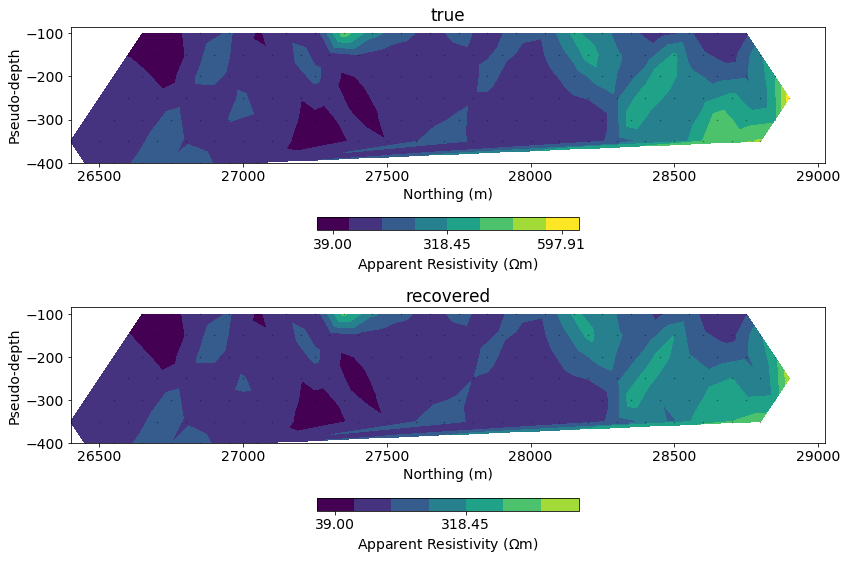

In [28]:
# plot psuedosection
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

clim = np.r_[apparent_resistivity.min(), apparent_resistivity.max()]

for a, data, title in zip(
    ax,
    [dc_data.dobs, invProb.dpred],
    ["true", "recovered"]
): 
    dc.utils.plot_pseudosection(
        dc_data, dobs=data, data_type="apparent resistivity",
        plot_type="contourf", data_location=True, ax=a, 
        cbar_opts={"pad":0.25}, clim=clim
    )
    a.set_title(title)


for a in ax: 
    a.set_aspect(1.5)  # some vertical exxageration
    a.set_xlabel("Northing (m)")
    a.set_ylabel("Pseudo-depth")

plt.tight_layout()



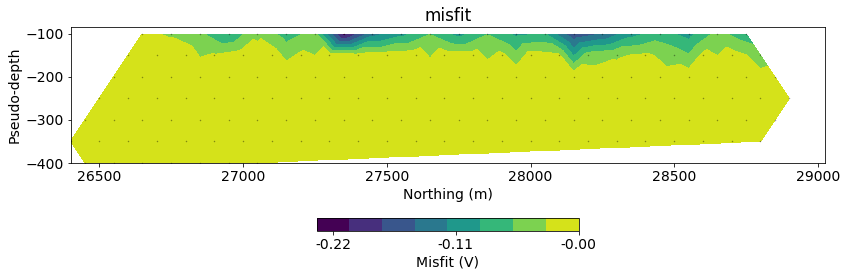

In [29]:
# plot misfit
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

dc.utils.plot_pseudosection(
    dc_data, dobs=invProb.dpred, data_type="misfit",
    plot_type="contourf", data_location=True, ax=ax, 
    cbar_opts={"pad":0.25}
)

ax.set_title("misfit")
ax.set_aspect(1.5)  # some vertical exxageration
ax.set_xlabel("Northing (m)")
ax.set_ylabel("Pseudo-depth")

plt.tight_layout()



In [30]:
# run inversion, plot tikhonov curves

def load_leapfrog_geologic_section(filename="./century/geologic_section.csv"):
    fid = open(filename, 'r')
    lines = fid.readlines()
    data = []
    data_tmp = []
    for line in lines[2:]:
        line_data = (line.split(',')[:3])
        if 'End' in line:
            data.append(np.vstack(data_tmp)[:,[0, 2]])
            data_tmp = []
        else:
            data_tmp.append(np.array(line_data, dtype=float))
    return data

In [31]:
geologic_section = load_leapfrog_geologic_section()

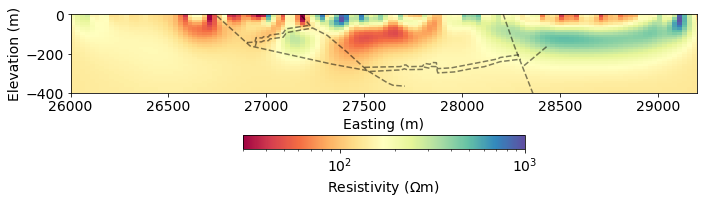

In [32]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
rho = 1./(mapping*mopt)
out = mesh.plotImage(
    rho, pcolorOpts={'norm':LogNorm(), 'cmap':'Spectral'}, ax=ax,
    clim=(30, 1000)
)
for data in geologic_section:
    ax.plot(data[:,0], data[:,1], 'k--', alpha=0.5)
ax.set_xlim(domain_x)
ax.set_ylim((-400, 0))
cb = plt.colorbar(out[0], fraction=0.05, orientation='horizontal', ax=ax)
cb.set_label("Resistivity ($\Omega$m)")
ax.set_aspect(1.)
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Elevation (m)')
plt.tight_layout()

<img src="images/Mutton-Figure2-1.png">